# Introduction

This notebook presents the main part of the project. It is decomposed in the following parts:
- Parameters setting 
- Creation of the trading environment 
- Set-up of the trading agent (actor)
- Set-up of the portfolio vector memory (PVM)
- Agent training 
- Agent Evaluation
- Analysis 

<u>Note:</u> This notebook has been cleaned up and run on a local machine. The appearing results are only for illustration and not representative of the project results in the presentation. 

# Imports

In [3]:
import tensorflow as tf
import numpy as np
from collections import deque
import random
import pandas as pd
import ffn
from src.environment import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

# Parameters

In [4]:
# dataset

#can be changed following the type of stocks studied 

path_data = './np_data/inputCrypto.npy'


data_type = path_data.split('/')[2][5:].split('.')[0]
namesBio=['JNJ','PFE','AMGN','MDT','CELG','LLY']
namesUtilities=['XOM','CVX','MRK','SLB','MMM']
namesTech=['FB','AMZN','MSFT','AAPL','T','VZ','CMCSA','IBM','CRM','INTC']
namesCrypto = ['ETCBTC', 'ETHBTC', 'DOGEBTC', 'ETHUSDT', 'BTCUSDT', 'XRPBTC', 'DASHBTC', 'XMRBTC', 'LTCBTC', 'ETCETH']


if data_type == 'Utilities':
    list_stock = namesUtilities
elif data_type == 'Bio':
    list_stock = namesBio
elif data_type == 'Tech':
    list_stock = namesTech
elif data_type == 'Crypto':
    list_stock = namesCrypto
else:
    list_stock = [i for i in range(m)]


# determine the length of the data, #features, #stocks
data = np.load(path_data)
trading_period = data.shape[2]
nb_feature_map = data.shape[0]
nb_stocks = data.shape[1]

# fix parameters of the network
m = nb_stocks

###############################dictionaries of the problem###########################
dict_hp_net = {'n_filter_1': 2, 'n_filter_2': 20, 'kernel1_size':(1, 3)}
dict_hp_pb = {'batch_size': 50, 'ratio_train': 0.6,'ratio_val': 0.2, 'length_tensor': 10,
              'ratio_greedy':0.8, 'ratio_regul': 0.1}
dict_hp_opt = {'regularization': 1e-8, 'learning': 9e-2}
dict_fin = {'trading_cost': 0.25/100, 'interest_rate': 0.02/250, 'cash_bias_init': 0.7}
dict_train = {'pf_init_train': 10000, 'w_init_train': 'd', 'n_episodes':2, 'n_batches':10}
dict_test = {'pf_init_test': 10000, 'w_init_test': 'd'}


###############################HP of the network ###########################
n_filter_1 = dict_hp_net['n_filter_1']
n_filter_2 = dict_hp_net['n_filter_2']
kernel1_size = dict_hp_net['kernel1_size']

###############################HP of the problem###########################

# Size of mini-batch during training
batch_size = dict_hp_pb['batch_size']
# Total number of steps for pre-training in the training set
total_steps_train = int(dict_hp_pb['ratio_train']*trading_period)

# Total number of steps for pre-training in the validation set
total_steps_val = int(dict_hp_pb['ratio_val']*trading_period)

# Total number of steps for the test
total_steps_test = trading_period-total_steps_train-total_steps_val

# Number of the columns (number of the trading periods) in each input price matrix
n = dict_hp_pb['length_tensor']

ratio_greedy = dict_hp_pb['ratio_greedy']

ratio_regul = dict_hp_pb['ratio_regul']

##############################HP of the optimization###########################


# The L2 regularization coefficient applied to network training
regularization = dict_hp_opt['regularization']
# Parameter alpha (i.e. the step size) of the Adam optimization
learning = dict_hp_opt['learning']

optimizer = tf.train.AdamOptimizer(learning)


##############################Finance parameters###########################

trading_cost= dict_fin['trading_cost']
interest_rate= dict_fin['interest_rate']
cash_bias_init = dict_fin['cash_bias_init']

############################## PVM Parameters ###########################
sample_bias = 5e-5  # Beta in the geometric distribution for online training sample batches


############################## Training Parameters ###########################

w_init_train = np.array(np.array([1]+[0]*m))#dict_train['w_init_train']

pf_init_train = dict_train['pf_init_train']

n_episodes = dict_train['n_episodes']
n_batches = dict_train['n_batches']

############################## Test Parameters ###########################

w_init_test = np.array(np.array([1]+[0]*m))#dict_test['w_init_test']

pf_init_test = dict_test['pf_init_test']


############################## other environment Parameters ###########################

w_eq = np.array(np.array([1/(m+1)]*(m+1)))

w_s = np.array(np.array([1]+[0.0]*m))


In [5]:
#random action function

def get_random_action(m):
    random_vec = np.random.rand(m+1)
    return random_vec/np.sum(random_vec)

In [6]:
#get_random_action(m)

# Environment creation

In [7]:
#environment for trading of the agent 
# this is the agent trading environment (policy network agent)
env = TradeEnv(path=path_data, window_length=n,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=dict_hp_pb['ratio_train'])


#environment for equiweighted
#this environment is set up for an agent who only plays an equiweithed portfolio (baseline)
env_eq = TradeEnv(path=path_data, window_length=n,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=dict_hp_pb['ratio_train'])

#environment secured (only money)
#this environment is set up for an agentwho plays secure, keeps its money
env_s = TradeEnv(path=path_data, window_length=n,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=dict_hp_pb['ratio_train'])


In [8]:
#full on one stock environment 
#these environments are set up for agents who play only on one stock

action_fu = list()
env_fu = list()


for i in range(m):
    action = np.array([0]*(i+1) + [1] + [0]*(m-(i+1)))
    action_fu.append(action)
    
    env_fu_i = TradeEnv(path=path_data, window_length=n,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=dict_hp_pb['ratio_train'])
    
    env_fu.append(env_fu_i)

    
    
    

# Definition of the Actor

In [9]:
# define neural net \pi_\phi(s) as a class
class Policy(object):
    '''
    This class is used to instanciate the policy network agent

    '''

    def __init__(self, m, n, sess, optimizer,
                 trading_cost=trading_cost,
                 interest_rate=interest_rate,
                 n_filter_1=n_filter_1,
                 n_filter_2=n_filter_2):

        # parameters
        self.trading_cost = trading_cost
        self.interest_rate = interest_rate
        self.n_filter_1 = n_filter_1
        self.n_filter_2 = n_filter_2
        self.n = n
        self.m = m

        with tf.variable_scope("Inputs"):

            # Placeholder

            # tensor of the prices
            self.X_t = tf.placeholder(
                tf.float32, [None, nb_feature_map, self.m, self.n])  # The Price tensor
            # weights at the previous time step
            self.W_previous = tf.placeholder(tf.float32, [None, self.m+1])
            # portfolio value at the previous time step
            self.pf_value_previous = tf.placeholder(tf.float32, [None, 1])
            # vector of Open(t+1)/Open(t)
            self.dailyReturn_t = tf.placeholder(tf.float32, [None, self.m])
            
            #self.pf_value_previous_eq = tf.placeholder(tf.float32, [None, 1])
            
            

        with tf.variable_scope("Policy_Model"):

            # variable of the cash bias
            bias = tf.get_variable('cash_bias', shape=[
                                   1, 1, 1, 1], initializer=tf.constant_initializer(cash_bias_init))
            # shape of the tensor == batchsize
            shape_X_t = tf.shape(self.X_t)[0]
            # trick to get a "tensor size" for the cash bias
            self.cash_bias = tf.tile(bias, tf.stack([shape_X_t, 1, 1, 1]))
            # print(self.cash_bias.shape)

            with tf.variable_scope("Conv1"):
                # first layer on the X_t tensor
                # return a tensor of depth 2
                self.conv1 = tf.layers.conv2d(
                    inputs=tf.transpose(self.X_t, perm=[0, 3, 2, 1]),
                    activation=tf.nn.relu,
                    filters=self.n_filter_1,
                    strides=(1, 1),
                    kernel_size=kernel1_size,
                    padding='same')

            with tf.variable_scope("Conv2"):
                
                #feature maps
                self.conv2 = tf.layers.conv2d(
                    inputs=self.conv1,
                    activation=tf.nn.relu,
                    filters=self.n_filter_2,
                    strides=(self.n, 1),
                    kernel_size=(1, self.n),
                    padding='same')

            with tf.variable_scope("Tensor3"):
                #w from last periods
                # trick to have good dimensions
                w_wo_c = self.W_previous[:, 1:]
                w_wo_c = tf.expand_dims(w_wo_c, 1)
                w_wo_c = tf.expand_dims(w_wo_c, -1)
                self.tensor3 = tf.concat([self.conv2, w_wo_c], axis=3)

            with tf.variable_scope("Conv3"):
                #last feature map WITHOUT cash bias
                self.conv3 = tf.layers.conv2d(
                    inputs=self.conv2,
                    activation=tf.nn.relu,
                    filters=1,
                    strides=(self.n_filter_2 + 1, 1),
                    kernel_size=(1, 1),
                    padding='same')

            with tf.variable_scope("Tensor4"):
                #last feature map WITH cash bias
                self.tensor4 = tf.concat([self.cash_bias, self.conv3], axis=2)
                # we squeeze to reduce and get the good dimension
                self.squeezed_tensor4 = tf.squeeze(self.tensor4, [1, 3])

            with tf.variable_scope("Policy_Output"):
                # softmax layer to obtain weights
                self.action = tf.nn.softmax(self.squeezed_tensor4)

            with tf.variable_scope("Reward"):
                # computation of the reward
                #please look at the chronological map to understand
                constant_return = tf.constant(
                    1+self.interest_rate, shape=[1, 1])
                cash_return = tf.tile(
                    constant_return, tf.stack([shape_X_t, 1]))
                y_t = tf.concat(
                    [cash_return, self.dailyReturn_t], axis=1)
                Vprime_t = self.action * self.pf_value_previous
                Vprevious = self.W_previous*self.pf_value_previous

                # this is just a trick to get the good shape for cost
                constant = tf.constant(1.0, shape=[1])

                cost = self.trading_cost * \
                    tf.norm(Vprime_t-Vprevious, ord=1, axis=1)*constant

                cost = tf.expand_dims(cost, 1)

                zero = tf.constant(
                    np.array([0.0]*m).reshape(1, m), shape=[1, m], dtype=tf.float32)

                vec_zero = tf.tile(zero, tf.stack([shape_X_t, 1]))
                vec_cost = tf.concat([cost, vec_zero], axis=1)

                Vsecond_t = Vprime_t - vec_cost

                V_t = tf.multiply(Vsecond_t, y_t)
                self.portfolioValue = tf.norm(V_t, ord=1)
                self.instantaneous_reward = (
                    self.portfolioValue-self.pf_value_previous)/self.pf_value_previous
                
                
            with tf.variable_scope("Reward_Equiweighted"):
                constant_return = tf.constant(
                    1+self.interest_rate, shape=[1, 1])
                cash_return = tf.tile(
                    constant_return, tf.stack([shape_X_t, 1]))
                y_t = tf.concat(
                    [cash_return, self.dailyReturn_t], axis=1)
  

                V_eq = w_eq*self.pf_value_previous
                V_eq_second = tf.multiply(V_eq, y_t)
        
                self.portfolioValue_eq = tf.norm(V_eq_second, ord=1)
            
                self.instantaneous_reward_eq = (
                    self.portfolioValue_eq-self.pf_value_previous)/self.pf_value_previous
                
            with tf.variable_scope("Max_weight"):
                self.max_weight = tf.reduce_max(self.action)
                print(self.max_weight.shape)

                
            with tf.variable_scope("Reward_adjusted"):
                
                self.adjested_reward = self.instantaneous_reward - self.instantaneous_reward_eq - ratio_regul*self.max_weight
                
        #objective function 
        #maximize reward over the batch 
        # min(-r) = max(r)
        self.train_op = optimizer.minimize(-self.adjested_reward)
        
        # some bookkeeping
        self.optimizer = optimizer
        self.sess = sess

    def compute_W(self, X_t_, W_previous_):
        """
        This function returns the action the agent takes 
        given the input tensor and the W_previous
        
        It is a vector of weight

        """

        return self.sess.run(tf.squeeze(self.action), feed_dict={self.X_t: X_t_, self.W_previous: W_previous_})

    def train(self, X_t_, W_previous_, pf_value_previous_, dailyReturn_t_):
        """
        This function trains the neural network
        maximizing the reward 
        the input is a batch of the differents values
        """
        self.sess.run(self.train_op, feed_dict={self.X_t: X_t_,
                                                self.W_previous: W_previous_,
                                                self.pf_value_previous: pf_value_previous_,
                                                self.dailyReturn_t: dailyReturn_t_})

# Definition of the PVM Class

In [10]:
class PVM(object):
    '''
    This is the memory stack called PVM in the paper
    '''

    def __init__(self, m, sample_bias, total_steps = total_steps_train, 
                 batch_size = batch_size, w_init = w_init_train):
        
        
        #initialization of the memory 
        #we have a total_step_times the initialization portfolio tensor 
        self.memory = np.transpose(np.array([w_init]*total_steps))  
        self.sample_bias = sample_bias
        self.total_steps = total_steps
        self.batch_size = batch_size

    def get_W(self, t):
        #return the weight from the PVM at time t 
        return self.memory[:, t]

    def update(self, t, w):
        #update the weight at time t
        self.memory[:, t] = w


    def draw(self, beta=sample_bias):
        '''
        returns a valid step so you can get a training batch starting at this step
        '''
        while 1:
            z = np.random.geometric(p=beta)
            tb = self.total_steps - self.batch_size + 1 - z
            if tb >= 0:
                return tb
            
    def test(self):
        #just to test
        return self.memory

Try to rollout trajecories using the policy

In [11]:
def get_max_draw_down(xs):
    xs = np.array(xs)
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    
    return xs[j] - xs[i]
    

In [12]:
def eval_perf(e):
    """
    This function evaluates the performance of the different types of agents. 
    
    
    """
    list_weight_end_val = list()
    list_pf_end_training = list()
    list_pf_min_training = list()
    list_pf_max_training = list()
    list_pf_mean_training = list()
    list_pf_dd_training = list()
    
    #######TEST#######
    #environment for trading of the agent 
    env_eval = TradeEnv(path=path_data, window_length=n,
                   portfolio_value=pf_init_train, trading_cost=trading_cost,
                   interest_rate=interest_rate, train_size=dict_hp_pb['ratio_train'])



    #initialization of the environment 
    state_eval, done_eval = env_eval.reset(w_init_test, pf_init_test, t = total_steps_train)



    #first element of the weight and portfolio value 
    p_list_eval = [pf_init_test]
    w_list_eval = [w_init_test]

    for k in range(total_steps_train, total_steps_train +total_steps_val-int(n/2)):
        X_t = state_eval[0].reshape([-1]+ list(state_eval[0].shape))
        W_previous = state_eval[1].reshape([-1]+ list(state_eval[1].shape))
        pf_value_previous = state_eval[2]
        #compute the action 
        action = actor.compute_W(X_t, W_previous)
        #step forward environment 
        state_eval, reward_eval, done_eval = env_eval.step(action)

        X_next = state_eval[0]
        W_t_eval = state_eval[1]
        pf_value_t_eval = state_eval[2]

        dailyReturn_t = X_next[-1, :, -1]
        #print('current portfolio value', round(pf_value_previous,0))
        #print('weights', W_previous)
        p_list_eval.append(pf_value_t_eval)
        w_list_eval.append(W_t_eval)
        
    list_weight_end_val.append(w_list_eval[-1])
    list_pf_end_training.append(p_list_eval[-1])
    list_pf_min_training.append(np.min(p_list_eval))
    list_pf_max_training.append(np.max(p_list_eval))
    list_pf_mean_training.append(np.mean(p_list_eval))
    
    list_pf_dd_training.append(get_max_draw_down(p_list_eval))

    print('End of test PF value:',round(p_list_eval[-1]))
    print('Min of test PF value:',round(np.min(p_list_eval)))
    print('Max of test PF value:',round(np.max(p_list_eval)))
    print('Mean of test PF value:',round(np.mean(p_list_eval)))
    print('Max Draw Down of test PF value:',round(get_max_draw_down(p_list_eval)))
    print('End of test weights:',w_list_eval[-1])
    plt.title('Portfolio evolution (validation set) episode {}'.format(e))
    plt.plot(p_list_eval, label = 'Agent Portfolio Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.title('Portfolio weights (end of validation set) episode {}'.format(e))
    plt.bar(np.arange(m+1), list_weight_end_val[-1])
    plt.xticks(np.arange(m+1), ['Money'] + list_stock, rotation=45)
    plt.show()
    
    
    names = ['Money'] + list_stock
    w_list_eval = np.array(w_list_eval)
    for j in range(m+1):
        plt.plot(w_list_eval[:,j], label = 'Weight Stock {}'.format(names[j]))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
    plt.show()


    

# RL Algorithm

In [13]:
############# TRAINING #####################
###########################################
tf.reset_default_graph()

# sess
sess = tf.Session()

# initialize networks
actor = Policy(m, n, sess, optimizer,
                 trading_cost=trading_cost, 
                 interest_rate=interest_rate)  # policy initialization

# initialize tensorflow graphs
sess.run(tf.global_variables_initializer())



list_final_pf = list()
list_final_pf_eq = list()
list_final_pf_s = list()

list_final_pf_fu = list()
state_fu = [0]*m
done_fu = [0]*m

pf_value_t_fu = [0]*m

for i in range(m):
    list_final_pf_fu.append(list())
    

###### Train #####
for e in range(n_episodes):
    print('Start Episode', e)
    if e==0:
        eval_perf('Before Training')
    print('Episode:', e)
    #init the PVM with the training parameters
    memory = PVM(m,sample_bias, total_steps = total_steps_train, 
                 batch_size = batch_size, w_init = w_init_train)
    
    for nb in range(n_batches):
        #draw the starting point of the batch 
        i_start = memory.draw()
        
        
        #reset the environment with the weight from PVM at the starting point
        #reset also with a portfolio value with initial portfolio value
        state, done = env.reset(memory.get_W(i_start), pf_init_train, t=i_start )
        state_eq, done_eq = env_eq.reset(w_eq, pf_init_train, t=i_start )
        state_s, done_s = env_s.reset(w_s, pf_init_train, t=i_start )
        
        for i in range(m):
            state_fu[i], done_fu[i] = env_fu[i].reset(action_fu[i], pf_init_train, t=i_start )
        
        
        
        list_X_t, list_W_previous, list_pf_value_previous, list_dailyReturn_t = [], [], [], []
        list_pf_value_previous_eq, list_pf_value_previous_s = [],[]
        list_pf_value_previous_fu = list()
        for i in range(m):
            list_pf_value_previous_fu.append(list())
            
        
        
        
        
        for bs in range(batch_size):
            
            #load the different inputs from the previous loaded state 
            X_t = state[0].reshape([-1] + list(state[0].shape))
            W_previous = state[1].reshape([-1] + list(state[1].shape))
            pf_value_previous = state[2]
            
            
            if np.random.rand()< ratio_greedy:
                #print('go')
                #computation of the action of the agent
                action = actor.compute_W(X_t, W_previous)
            else:
                action = get_random_action(m)
            
            #given the state and the action, call the environment to go one time step later 
            state, reward, done = env.step(action)
            state_eq, reward_eq, done_eq = env_eq.step(w_eq)
            state_s, reward_s, done_s = env_s.step(w_s)
            
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])

            
            
            #get the new state 
            X_next = state[0]
            W_t = state[1]
            pf_value_t = state[2]
            
            pf_value_t_eq = state_eq[2]
            pf_value_t_s = state_s[2]
            
            for i in range(m):
                pf_value_t_fu[i] = state_fu[i][2]
                
            
            #let us compute the returns 
            dailyReturn_t = X_next[-1, :, -1]
            #update into the PVM
            memory.update(i_start+bs, W_t)
            #store elements
            list_X_t.append(X_t.reshape(state[0].shape))
            list_W_previous.append(W_previous.reshape(state[1].shape))
            list_pf_value_previous.append([pf_value_previous])
            list_dailyReturn_t.append(dailyReturn_t)
            
            list_pf_value_previous_eq.append(pf_value_t_eq)
            list_pf_value_previous_s.append(pf_value_t_s)
            
            for i in range(m):
                list_pf_value_previous_fu[i].append(pf_value_t_fu[i])
            
            if bs==batch_size-1:
                list_final_pf.append(pf_value_t)
                list_final_pf_eq.append(pf_value_t_eq)
                list_final_pf_s.append(pf_value_t_s)
                for i in range(m):
                    list_final_pf_fu[i].append(pf_value_t_fu[i])

            
            
#             #printing
#             if bs==0:
#                 print('start', i_start)
#                 print('PF_start', round(pf_value_previous,0))

#             if bs==batch_size-1:
#                 print('PF_end', round(pf_value_t,0))
#                 print('weight', W_t)

        list_X_t = np.array(list_X_t)
        list_W_previous = np.array(list_W_previous)
        list_pf_value_previous = np.array(list_pf_value_previous)
        list_dailyReturn_t = np.array(list_dailyReturn_t)
        
        
        #for each batch, train the network to maximize the reward
        actor.train(list_X_t, list_W_previous,
                    list_pf_value_previous, list_dailyReturn_t)
    eval_perf(e)

()
Start Episode 0


TypeError: reset() got an unexpected keyword argument 't'

# Testing

In [37]:
#######TEST#######


#initialization of the environment 
state, done = env.reset(w_init_test, pf_init_test, t = total_steps_train)

state_eq, done_eq = env_eq.reset(w_eq, pf_init_test, t = total_steps_train)
state_s, done_s = env_s.reset(w_s, pf_init_test, t = total_steps_train)

for i in range(m):
    state_fu[i],  done_fu[i] = env_fu[i].reset(action_fu[i], pf_init_test, t = total_steps_train)


#first element of the weight and portfolio value 
p_list = [pf_init_test]
w_list = [w_init_test]

p_list_eq = [pf_init_test]
p_list_s = [pf_init_test]


p_list_fu = list()
for i in range(m):
    p_list_fu.append([pf_init_test])
    
pf_value_t_fu = [0]*m
    

for k in range(total_steps_train +total_steps_val-int(n/2), total_steps_train +total_steps_val +total_steps_test -n):
    X_t = state[0].reshape([-1]+ list(state[0].shape))
    W_previous = state[1].reshape([-1]+ list(state[1].shape))
    pf_value_previous = state[2]
    #compute the action 
    action = actor.compute_W(X_t, W_previous)
    #step forward environment 
    state, reward, done = env.step(action)
    state_eq, reward_eq, done_eq = env_eq.step(w_eq)
    state_s, reward_s, done_s = env_s.step(w_s)
    
    
    for i in range(m):
        state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
    
    
    X_next = state[0]
    W_t = state[1]
    pf_value_t = state[2]
    
    pf_value_t_eq = state_eq[2]
    pf_value_t_s = state_s[2]
    for i in range(m):
        pf_value_t_fu[i] = state_fu[i][2]
    
    dailyReturn_t = X_next[-1, :, -1]
    if k%20 == 0:
        print('current portfolio value', round(pf_value_previous,0))
        print('weights', W_previous)
    p_list.append(pf_value_t)
    w_list.append(W_t)
    
    p_list_eq.append(pf_value_t_eq)
    p_list_s.append(pf_value_t_s)
    for i in range(m):
        p_list_fu[i].append(pf_value_t_fu[i])
        
    #here to breack the loop/not in original code     
    if k== total_steps_train +total_steps_val-int(n/2) + 100:
        break
    
    

current portfolio value 9993.0
weights [[0.0062508  0.09846592 0.09850711 0.10444584 0.09894872 0.09924217
  0.09801345 0.09904172 0.09938086 0.09867361 0.0990298 ]]
current portfolio value 9934.0
weights [[0.01120021 0.0989992  0.09938443 0.09901933 0.09898423 0.09875402
  0.09882854 0.09857667 0.09865061 0.09902017 0.09858258]]
current portfolio value 9915.0
weights [[0.01120294 0.0988903  0.09869209 0.09903787 0.09903787 0.0986621
  0.09903787 0.09903787 0.09903813 0.09855022 0.09881274]]
current portfolio value 9933.0
weights [[0.0111087  0.09837    0.09840221 0.10416636 0.09848968 0.09846496
  0.09857186 0.09745443 0.09851925 0.09817885 0.09827371]]
current portfolio value 9967.0
weights [[0.01113317 0.09852288 0.09831241 0.09871878 0.09879521 0.09888554
  0.09832548 0.10059552 0.09831937 0.09900841 0.09938323]]


# Analysis

In [38]:
path = "individual_stocks_5yr/"
times = pd.read_csv(path+"A_data.csv").date
test_start_day =total_steps_train +total_steps_val-int(n/2)+10
times = list(times[test_start_day:])

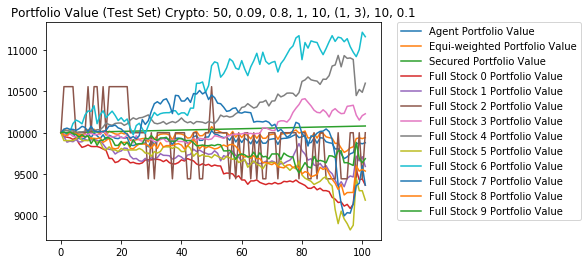

In [39]:
#batch_size, learning, ratio_greedy, e, n, kernel1_size, n_batches, ratio_regul

data_type = path_data.split('/')[2][5:].split('.')[0]
namesBio=['JNJ','PFE','AMGN','MDT','CELG','LLY']
namesUtilities=['XOM','CVX','MRK','SLB','MMM']
namesTech=['FB','AMZN','MSFT','AAPL','T','VZ','CMCSA','IBM','CRM','INTC']


if data_type == 'Utilities':
    list_stock = namesUtilities
elif data_type == 'Bio':
    list_stock = namesBio
elif data_type == 'Tech':
    list_stock = namesTech
else:
    list_stock = [i for i in range(m)]


plt.title('Portfolio Value (Test Set) {}: {}, {}, {}, {}, {}, {}, {}, {}'.format(data_type, batch_size, learning, ratio_greedy, e, n, kernel1_size, n_batches, ratio_regul))
plt.plot(p_list, label = 'Agent Portfolio Value')
plt.plot(p_list_eq, label = 'Equi-weighted Portfolio Value')
plt.plot(p_list_s, label = 'Secured Portfolio Value')
for i in range(m):
    plt.plot(p_list_fu[i], label = 'Full Stock {} Portfolio Value'.format(list_stock[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

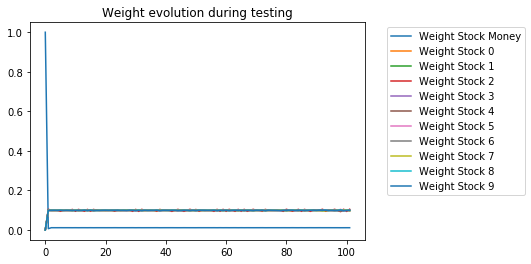

In [40]:
names = ['Money'] + list_stock
w_list = np.array(w_list)
for j in range(m+1):
    plt.plot(w_list[:,j], label = 'Weight Stock {}'.format(names[j]))
    plt.title('Weight evolution during testing')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

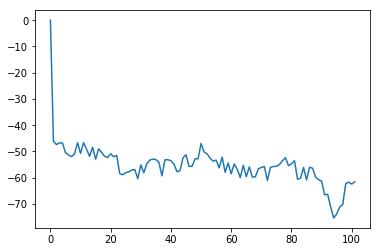

In [42]:
plt.plot(np.array(p_list)-np.array(p_list_eq))

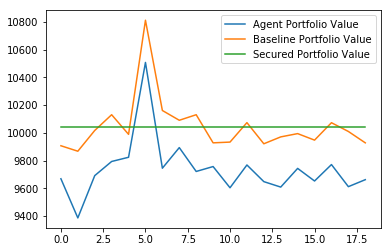

In [45]:
index1=0
index2=-1

plt.plot(list_final_pf[index1:index2], label = 'Agent Portfolio Value')
plt.plot(list_final_pf_eq[index1:index2], label = 'Baseline Portfolio Value')
plt.plot(list_final_pf_s[index1:index2], label = 'Secured Portfolio Value')
plt.legend()
plt.show()

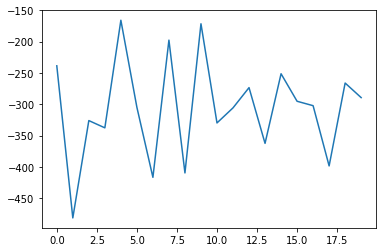

In [46]:
plt.plot((np.array(list_final_pf)-np.array(list_final_pf_eq)))